What this notebook does:

- implement the normal mnist network from the homework </br>
- testing and comparing different values for certain hyperparamters like 
    - number of units per hidden layer </br>
    - number of hidden layers </br>
    - momentum </br>
    - step size </br>
    - number of epochs </br>

Each of these comparison has it's own cell that can be run independently.
Click 'run all' on your own risk, it may take quite a while!

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

2022-11-14 12:12:11.480249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-11-14 12:12:12.346856: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-14 12:12:12.347418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-14 12:12:12.366755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 12:12:12.366857: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: NVIDIA GeForce RTX 3070 computeCapability: 8.6
coreClock: 1.725GHz coreCount: 46 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-11-14 12:12:12.366868: I tensorflow/stream_executor/platform/de

In [4]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/home/hendrik/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

How many training/test images are there? </br>
training: 60000 </br>
test: 10000

What's the image shape? </br>
28 * 28 

What range are pixel values in? </br>
8 bit -> 0 to 255

2022-11-14 12:12:13.355019: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-11-14 12:12:13.355250: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3792895000 Hz
2022-11-14 12:12:13.366860: W tensorflow/core/kernels/data/cache_dataset_ops.cc:757] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


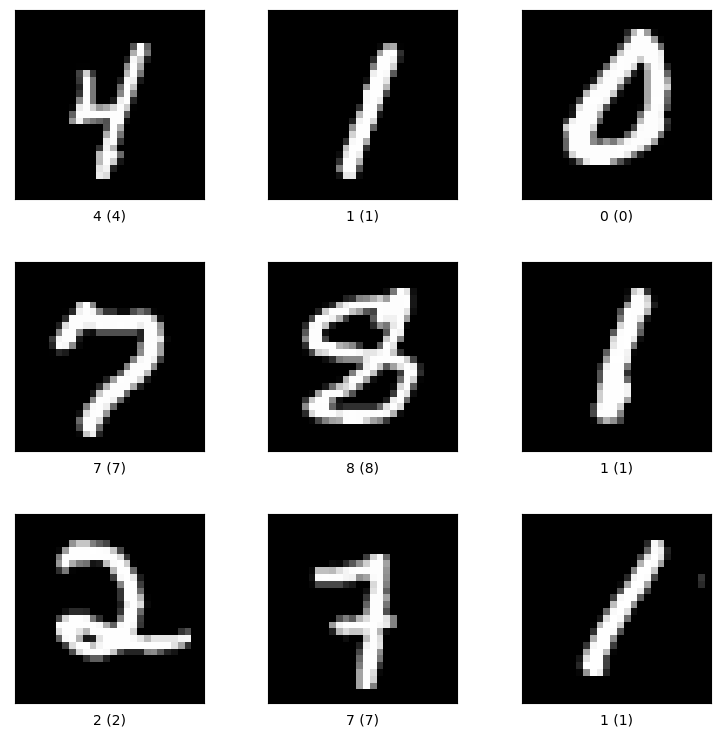

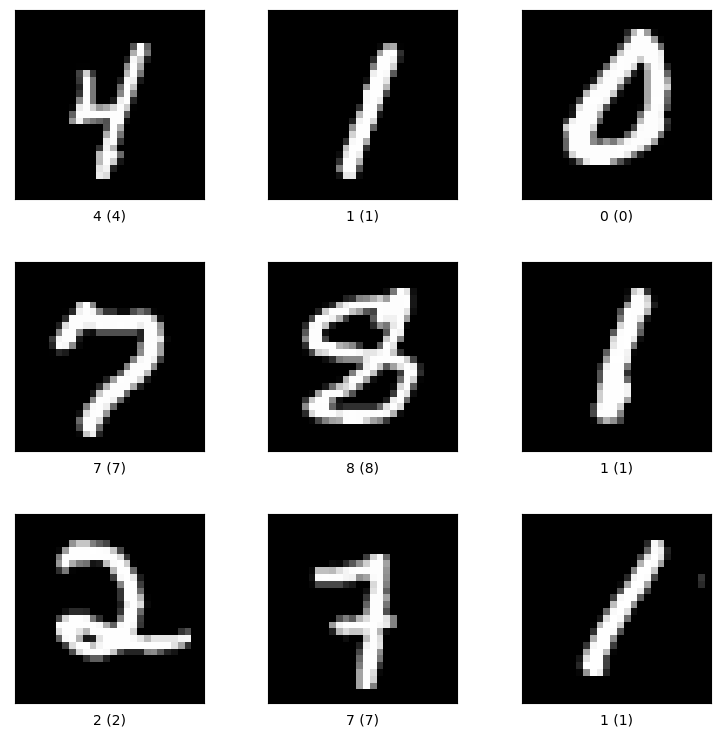

In [5]:
tfds.show_examples(train_ds, ds_info)

In [6]:
# building the data pipeline

def prepare_mnist_data(mnist):
    # flatten the images into vectors
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1,)), target))
    # convert data from uint8 to float32
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # bringing image values from range [0,255] to [-1,1]
    mnist = mnist.map(lambda img, target: ((img/128.)-1., target))
    # create one-hot targets
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
    # cache progress in memory
    mnist = mnist.cache()
    # shuffle, batch, prefetch
    mnist = mnist.shuffle(1000)
    mnist = mnist.batch(32)
    mnist = mnist.prefetch(20)
    # return processed dataset
    return mnist

train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [7]:
# prepare the model
from tensorflow.keras.layers import Dense

class MyModel(tf.keras.Model):
    
    # two hidden layers + output layer
    def __init__(self, n_units):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_units, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(n_units, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    
    # propagate the input through all layers until the output
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [8]:
# prepare training and test functions
import numpy as np

# backpropagation using the GradientTape to get the gradients and then apply them via the optimizer
def train_step(model, input, target, loss_function, optimizer):
    
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# to test with an independent data set, storing some metrics for every step
def test(model, test_data, loss_function):
    
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
        
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
    
    return test_loss, test_accuracy

In [9]:
# used the example from the homework sheet but removed the train accuracy
import matplotlib.pyplot as plt
def visualization (train_losses, test_losses, test_accuracies):
    """ Visualizes accuracy and loss for training and test data using
    the mean of each epoch .
    Loss is displayed in a regular line , accuracy in a dotted
    line .
    Training data is displayed in blue , test data in red .
    Parameters
    ----------
    train_losses : numpy.ndarray
    training losses
    training accuracies
    test_losses : numpy.ndarray
    test losses
    test_accuracies : numpy.ndarray
    test accuracies
    """
    print("train losses: ")
    print(train_losses)
    print("test losses: ")
    print(test_losses)
    print("test accuracies: ")
    print(test_accuracies)
    
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line4, = plt.plot(test_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line4), ("training loss", "test loss", "test accuracy"))
    plt.show()

In [ ]:
# the normal configuration from task 2
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.01

# Initialize the model
model = MyModel(256)
# Initialize the loss: categorial cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters.
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization
train_losses = []
#train_accuracies

test_losses = []
test_accuracies = []

# testing once before we begin
#test_loss, test_accuracy = test(model,test_dataset, cross_entropy_loss)
#test_losses.append(test_loss)
#test_accuracies.append(test_accuracy)

# check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)
#train_accuracies.append(train_accuracy)

# we train for num_epochs epochs.
for epoch in range(num_epochs):
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
        
    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))
    
    # testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
visualization(train_losses, test_losses, test_accuracies)

In [12]:
### run with different number of units per layer ###

tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.01

# Initialize the models
# create one model per entry in layer_sizes
layer_sizes = [24,23,22,21]
models = []
for i in range(len(layer_sizes)):
    model = MyModel(layer_sizes[i])
    models.append(model)
    
# Initialize the loss: categorial cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer: SGD with default parameters.
optimizer = tf.keras.optimizers.SGD(learning_rate)

n = 0

for model in models:
    
    # Initialize lists for later visualization
    train_losses = []
    #train_accuracies

    test_losses = []
    test_accuracies = []

    # testing once before we begin
    test_loss, test_accuracy = test(model,test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)

    # check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, cross_entropy_loss)
    train_losses.append(train_loss)
    #train_accuracies.append(train_accuracy)

    # we train for num_epochs epochs.
    for epoch in range(num_epochs):
        epoch_loss_agg = []
        for input,target in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
            epoch_loss_agg.append(train_loss)

        # track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        # testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    # printing the results (mostly interested in the accuracy of the test dataset)
    print("layer size: " + str(layer_sizes[n]))
    print("test accuracy: " + str(test_accuracies[-1]))
    n = n + 1 

layer size: 24
test accuracy: tf.Tensor(0.9491813099041534, shape=(), dtype=float64)
layer size: 23
test accuracy: tf.Tensor(0.9517771565495208, shape=(), dtype=float64)
layer size: 22
test accuracy: tf.Tensor(0.9464856230031949, shape=(), dtype=float64)
layer size: 21
test accuracy: tf.Tensor(0.9497803514376997, shape=(), dtype=float64)


Some results from running the above with different values:

layer size: 256 accuracy: 0.9739 </br>
layer size: 200 accuracy: 0.9697 </br>
layer size: 100 accuracy: 0.9667 </br>
layer size: 50 accuracy: 0.9634 </br>
layer size: 25 accuracy: 0.9531 </br>
layer size: 24 accuracy: 0.9491 </br>
layer size: 23 accuracy: 0.9517 </br>
layer size: 22 accuracy: 0.9464 </br>
layer size: 21 accuracy: 0.9667 </br>
layer size: 20 accuracy: 0.9460 </br>

-> probably reduceable to 20 with changing other parameters (when taking >95% as a threshold)

In [17]:
### run same layersize with different learning rates

tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rates = [0.04, 0.02, 0.01, 0.005, 0.001]

# Initialize the models
# since I tried to get a layersize of 20 to over 95% accuracy I just rolled with that from here
# this time we also need a different optimizer object for every model
layer_size = 20
models = []
optimizers = []
for i in range(len(learning_rates)):
    model = MyModel(layer_size)
    models.append(model)
    optimizer = tf.keras.optimizers.SGD(learning_rates[i])
    optimizers.append(optimizer)
    
# Initialize the loss: categorial cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()



for n in range(len(models)):
    
    # Initialize lists for later visualization
    train_losses = []
    #train_accuracies

    test_losses = []
    test_accuracies = []

    # testing once before we begin
    test_loss, test_accuracy = test(model,test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)

    # check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, cross_entropy_loss)
    train_losses.append(train_loss)
    #train_accuracies.append(train_accuracy)

    # we train for num_epochs epochs.
    for epoch in range(num_epochs):
        epoch_loss_agg = []
        for input,target in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizers[n])
            epoch_loss_agg.append(train_loss)

        # track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        # testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    # print accuracy
    print("step size: " + str(learning_rates[n]))
    print("test accuracy: " + str(test_accuracies[-1]))

step size: 0.04
test accuracy: tf.Tensor(0.9475838658146964, shape=(), dtype=float64)
step size: 0.02
test accuracy: tf.Tensor(0.9602635782747604, shape=(), dtype=float64)
step size: 0.01
test accuracy: tf.Tensor(0.959464856230032, shape=(), dtype=float64)
step size: 0.005
test accuracy: tf.Tensor(0.9601637380191693, shape=(), dtype=float64)
step size: 0.001
test accuracy: tf.Tensor(0.9615615015974441, shape=(), dtype=float64)


Some results from running the above with different values:

step size: 0.04 acccuracy: 0.9527 </br>
step size: 0.02 accuracy: 0.9580 </br>
step size: 0.01 accuracy: 0.9586 </br>
step size: 0.005 accuracy: 0.9586 </br>
step size: 0.001 accuracy: 0.9608 </br>

-> reducing step size gave a slight advantage in this case (n_units = 20)
But they can underly variance! (next run the accuracy might be closer to 0.90 or so)

In [16]:
### different momentum values

tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
# using the learning rate with the best results from the last test
learning_rate = 0.001
momentum_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

# Initialize the models
# again we need multiple optimizers with different paramters
layer_size = 20
models = []
optimizers = []
for i in range(len(momentum_values)):
    model = MyModel(layer_size)
    models.append(model)
    optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=momentum_values[i])
    optimizers.append(optimizer)
    
# Initialize the loss: categorial cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer: SGD with default parameters.
#optimizer = tf.keras.optimizers.SGD(learning_rate)


for n in range(len(models)):
    
    # Initialize lists for later visualization
    train_losses = []
    #train_accuracies

    test_losses = []
    test_accuracies = []

    # testing once before we begin
    test_loss, test_accuracy = test(model,test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)

    # check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, cross_entropy_loss)
    train_losses.append(train_loss)
    #train_accuracies.append(train_accuracy)

    # we train for num_epochs epochs.
    for epoch in range(num_epochs):
        epoch_loss_agg = []
        for input,target in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizers[n])
            epoch_loss_agg.append(train_loss)

        # track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        # testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    # print accuracy
    print("momentum: " + str(momentum_values[n]))
    print("test accuracy: " + str(test_accuracies[-1]))

step size: 0.9
test accuracy: tf.Tensor(0.9438897763578274, shape=(), dtype=float64)
step size: 1
test accuracy: tf.Tensor(0.0961461661341853, shape=(), dtype=float64)


Some previous results from running the above:

momentum: 0 accuracy: 0.9020 </br>
momentum: 0.2 accuracy: 0.9228 </br>
momentum: 0.4 accuracy: 0.9331 </br>
momentum: 0.6 accuracy: 0.9410 </br>
momentum: 0.8 accuracy: 0.9510 </br>
momentum: 0.9 accuracy: 0.9439 </br>
momentum: 1 accuracy: 0.0096 </br>

-> accuracy increased with momentum (as long as momentum < 1)

In [18]:
### different number of epochs

tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = [10, 15, 20, 25, 30, 50]
learning_rate = 0.001
# again, using the best result from above to continue with testing
momentum_value = 0.8

# Initialize the models
layer_size = 20
models = []
optimizers = []
for i in range(len(num_epochs)):
    model = MyModel(layer_size)
    models.append(model)    
    
# Initialize the loss: categorial cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer: SGD with default parameters.
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.8)

#train every model
for n in range(len(models)):
    
    # Initialize lists for later visualization
    train_losses = []
    #train_accuracies

    test_losses = []
    test_accuracies = []

    # testing once before we begin
    test_loss, test_accuracy = test(model,test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)

    # check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, cross_entropy_loss)
    train_losses.append(train_loss)
    #train_accuracies.append(train_accuracy)

    # we train for num_epochs epochs.
    for epoch in range(num_epochs[n]):
        epoch_loss_agg = []
        for input,target in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
            epoch_loss_agg.append(train_loss)

        # track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        # testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    #print accuracies
    print("epochs size: " + str(num_epochs[n]))
    print("test accuracy: " + str(test_accuracies[-1]))

epochs size: 10
test accuracy: tf.Tensor(0.9341054313099042, shape=(), dtype=float64)
epochs size: 15
test accuracy: tf.Tensor(0.952276357827476, shape=(), dtype=float64)
epochs size: 20
test accuracy: tf.Tensor(0.9564696485623003, shape=(), dtype=float64)
epochs size: 25
test accuracy: tf.Tensor(0.9582667731629393, shape=(), dtype=float64)
epochs size: 30
test accuracy: tf.Tensor(0.9562699680511182, shape=(), dtype=float64)
epochs size: 50
test accuracy: tf.Tensor(0.957867412140575, shape=(), dtype=float64)


epochs: 10 accuracy: 0.9341 </br>
epochs: 15 accuracy: 0.9523 </br>
epochs: 20 accuracy: 0.9564 </br>
epochs: 25 accuracy: 0.9583 </br>
epochs: 30 accuracy: 0.9563 </br>
epochs: 50 accuracy: 0.9579 </br>

-> only slight benefit of higher epochs but adding a lot of additional computations

In [21]:
### different number of layers

# Version of the MyModel where the number of layers is variable
# but every hidden layer will get the same number of units
from tensorflow.keras.layers import Dense

class MyModel2(tf.keras.Model):
    
    def __init__(self, n_layers, n_units):
        super(MyModel2, self).__init__()
        self.denseL = []
        for i in range(n_layers):
            self.denseL.append(tf.keras.layers.Dense(n_units, activation=tf.nn.relu))
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        
    @tf.function
    def call(self, inputs):
        x = inputs
        for layer in self.denseL:
            x = layer(x)
        x = self.out(x)
        return x
    

    
tf.keras.backend.clear_session()

# Hyperparameters
# as more epochs only marginaly increased performance I decided on 20 epochs, to keep computational effort lower
num_epochs = 20
learning_rate = 0.001
momentum_value = 0.8

# Initialize the models
layer_size = 20
num_layers = [1,2,3,4]
models = []
optimizers = []
for i in range(len(num_layers)):
    model = MyModel2(num_layers[i],layer_size)
    models.append(model)    
    
# Initialize the loss: categorial cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

# Initialize the optimizer: SGD with default parameters.
optimizer = tf.keras.optimizers.SGD(learning_rate, momentum=0.8)


for n in range(len(models)):
    
    # Initialize lists for later visualization
    train_losses = []
    #train_accuracies

    test_losses = []
    test_accuracies = []

    # testing once before we begin
    test_loss, test_accuracy = test(model,test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    #test_accuracies.append(test_accuracy)

    # check how model performs on train data once before we begin
    train_loss, _ = test(model, train_dataset, cross_entropy_loss)
    train_losses.append(train_loss)
    #train_accuracies.append(train_accuracy)

    # we train for num_epochs epochs.
    for epoch in range(num_epochs):
        epoch_loss_agg = []
        for input,target in train_dataset:
            train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
            epoch_loss_agg.append(train_loss)

        # track training loss
        train_losses.append(tf.reduce_mean(epoch_loss_agg))

        # testing, so we can track accuracy and test loss
        test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
    # get accuracy
    print("layers: " + str(num_layers[n]))
    print("test accuracy: " + str(test_accuracies[-1]))

layers: 1
test accuracy: tf.Tensor(0.9482827476038339, shape=(), dtype=float64)
layers: 2
test accuracy: tf.Tensor(0.9555710862619808, shape=(), dtype=float64)
layers: 3
test accuracy: tf.Tensor(0.9549720447284346, shape=(), dtype=float64)
layers: 4
test accuracy: tf.Tensor(0.954173322683706, shape=(), dtype=float64)


Some results from testing the above:

layers: 1 accuracy: 0.9483 </br>
layers: 2 accuracy: 0.9556 </br>
layers: 3 accuracy: 0.9550 </br>
layers: 4 accuracy: 0.9542 </br>

-> additional layers do not seem to increase performance in this case, even one layer already performed quite well. It could be that more layers require more training steps